The manual annotations are compared with the annotation by Gemini

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# get the annotations 

In [3]:
import pandas as pd

ocr_manual = pd.read_csv('ocr_manual_scores.csv')
ocr_gemini = pd.read_csv('ocr_gemini_scores.csv')

t5_manual = pd.read_csv('T5_manual_scores.csv')
t5_gemini = pd.read_csv('T5_gemini_scores_all_texts.csv')

bt_manual = pd.read_csv('Back_translation_manual_scores.csv')
bt_gemini = pd.read_csv('Back_translation_gemini_scores_all_texts.csv')

bart_manual = pd.read_csv('bart_manual_scores.csv')
bart_gemini = pd.read_csv('Bart_gemini_scores_all_texts.csv')

bt_t5_manual = pd.read_csv('Back_translation_t5_manual_scores.csv')
bt_t5_gemini = pd.read_csv('back_translation_t5_gemini_scores_all_texts.csv')

In [4]:
import json
import os

extract_dir = os.path.expanduser("~/work/MNLP-project-2/data/eng")
clean_path = os.path.join(extract_dir, "the_vampyre_clean.json")
with open(clean_path, "r", encoding="utf-8") as f:
    clean_data = json.load(f)

    
ocr_text = pd.read_csv("~/work/MNLP-project-2/data/eng/the_vampyre_ocr.csv")
bt_text = pd.read_csv("back_translation_correction.csv")
bart_text = pd.read_csv("bart_correction.csv")
t5_text = pd.read_csv("T5_correction.csv")
bt_t5_text = pd.read_csv("back_translation_t5_correction.csv")

In [30]:
t5_text.columns

Index(['index', 'original_text', 'corrected_text'], dtype='object')

In [31]:
bart_text.columns

Index(['index', 'original_text', 'corrected_text'], dtype='object')

In [32]:
bt_text.columns

Index(['index', 'original_text', 'translated_fr_text', 'back_translated_text'], dtype='object')

In [33]:
ocr_text.columns

Index(['id', 'texte'], dtype='object')

In [5]:
def concat_values_dict(d):
    """
    Concat values of a dict, seperating each element with '\n'

    Args:
        d (dict): Dictionnary

    Returns:
        str: concatenated text
    """
    return '\n'.join(d.get(str(i), "") for i in range(48))

clean_data_text = concat_values_dict(clean_data)

In [6]:
clean_data_text

'THE VAMPYRE;\nA Tale.\nBy John William Polidori\nTHE superstition upon which this tale is founded is very general in the East. Among the Arabians it appears to be common: it did not, however, extend itself to the Greeks until after the establishment of Christianity; and it has only assumed its present form since the division of the Latin and Greek churches; at which time, the idea becoming prevalent, that a Latin body could not corrupt if buried in their territory, it gradually increased, and formed the subject of many wonderful stories, still extant, of the dead rising from their graves, and feeding upon the blood of the young and beautiful. In the West it spread, with some slight variation, all over Hungary, Poland, Austria, and Lorraine, where the belief existed, that vampyres nightly imbibed a certain portion of the blood of their victims, who became emaciated, lost their strength, and speedily died of consumptions; whilst these human blood-suckers fattened—and their veins became 

# Rouge

In [7]:
!pip install rouge_score --quiet

  DEPRECATION: Building 'rouge_score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge_score'. Discussion can be found at https://github.com/pypa/pip/issues/6334


from rouge_score import rouge_scorer
import pandas as pd

tables_info = [
    {'df': bt_text, 'gen_col': 'back_translated_text', 'label': 'Back-Translation'},
    {'df': bart_text, 'gen_col': 'corrected_text', 'label': 'BART'},
    {'df': t5_text, 'gen_col': 'corrected_text', 'label': 'T5'},
    {'df': ocr_text, 'gen_col': 'texte', 'label': 'OCR'}
]

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

results = []

for info in tables_info:
    df = info['df']
    col = info['gen_col']
    label = info['label']
    
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []
    
    for pred_text in df[col]:
        scores = scorer.score(clean_data_text, pred_text)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougel_scores.append(scores['rougeL'].fmeasure)
        
    results.append({
        'Method': label,
        'ROUGE-1': sum(rouge1_scores)/len(rouge1_scores),
        'ROUGE-2': sum(rouge2_scores)/len(rouge2_scores),
        'ROUGE-L': sum(rougel_scores)/len(rougel_scores),
    })

results_df = pd.DataFrame(results)
print(results_df)

The code is to long to run, we only look at the 20 first sentences

In [8]:
import spacy
from rouge_score import rouge_scorer
import pandas as pd
from tqdm import tqdm

# Charger spaCy pour découper en phrases
nlp = spacy.load("en_core_web_sm")

# Fonction pour extraire les N premières phrases
def get_first_n_sentences(text, n=20):
    doc = nlp(text)
    return ' '.join([sent.text.strip() for sent in list(doc.sents)[:n]])

# Clean référence limité à 20 phrases
clean_trimmed = get_first_n_sentences(clean_data_text, n=20)

# Tables à analyser
tables_info = [
    {'df': bt_text, 'gen_col': 'back_translated_text', 'label': 'Back-Translation'},
    {'df': bart_text, 'gen_col': 'corrected_text', 'label': 'BART'},
    {'df': t5_text, 'gen_col': 'corrected_text', 'label': 'T5'},
    {'df': ocr_text, 'gen_col': 'texte', 'label': 'OCR'},
    {'df': bt_t5_text, 'gen_col': 'corrected_text', 'label': 'Back-Translation + T5'}
]

# Initialiser le scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Résultats
results = []

for info in tables_info:
    df = info['df']
    col = info['gen_col']
    label = info['label']

    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    print(f"Looking at {label}")
    for pred_text in tqdm(df[col], desc=f"→ {label}", leave=False):
        pred_trimmed = get_first_n_sentences(pred_text, n=20)
        scores = scorer.score(clean_trimmed, pred_trimmed)

        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougel_scores.append(scores['rougeL'].fmeasure)

    results.append({
        'Method': label,
        'ROUGE-1': sum(rouge1_scores) / len(rouge1_scores),
        'ROUGE-2': sum(rouge2_scores) / len(rouge2_scores),
        'ROUGE-L': sum(rougel_scores) / len(rougel_scores),
    })

# Affichage final
results_df = pd.DataFrame(results)
print(results_df)

Looking at Back-Translation


Looking at BART


Looking at T5


Looking at OCR


             Method   ROUGE-1   ROUGE-2   ROUGE-L
0  Back-Translation  0.721378  0.429506  0.640946
1              BART  0.854665  0.773830  0.843029
2                T5  0.829599  0.719153  0.818519
3               OCR  0.802600  0.657661  0.801306


# weighted sum of the scores of the chunks for each text

In [10]:
def compute_scores(df_manual, df_gemini):
    # Poids relatifs manuels
    manual_weights = [1.5, 1, 1]
    total_manual_weight = sum(manual_weights)
    
    # Poids normalisé pour chunk 0 dans Gemini (correspondant au score_fixed)
    weight_chunk0 = manual_weights[0] / total_manual_weight
    
    df_manual = df_manual.copy()
    norm_manual_weights = [w / total_manual_weight for w in manual_weights]
    
    # Calcul du score manuel pondéré
    df_manual['manual_score'] = df_manual[['score_fixed', 'score_random_1', 'score_random_2']].apply(
        lambda row: (
            row['score_fixed'] * norm_manual_weights[0] +
            row['score_random_1'] * norm_manual_weights[1] +
            row['score_random_2'] * norm_manual_weights[2]
        ),
        axis=1
    )
    
    df_gemini = df_gemini.copy()
    
    # Attribution des poids normalisés à chaque chunk
    def assign_normalized_weights(group):
        n_chunks = len(group)
        n_other_chunks = n_chunks - 1  # sauf chunk 0
        # Poids pour chunk 0
        group['normalized_weight'] = (1 - weight_chunk0) / n_other_chunks  # valeur par défaut
        group.loc[group['chunk_index'] == 0, 'normalized_weight'] = weight_chunk0
        return group

    df_gemini = df_gemini.groupby('text_index').apply(assign_normalized_weights).reset_index(drop=True)

    # Score pondéré Gemini
    gemini_scores = df_gemini.groupby('text_index').apply(
        lambda g: (g['score'] * g['normalized_weight']).sum()
    ).reset_index(name='gemini_score')

    # Fusion des résultats
    result = gemini_scores.merge(df_manual[['text_index', 'manual_score']], on='text_index')
    
    return result

# OCR

In [11]:
scores_ocr = compute_scores(ocr_manual, ocr_gemini)
scores_ocr.head()

,text_index,gemini_score,manual_score
0,0,3.592593,2.714286
1,1,3.925926,2.714286
2,2,3.518519,2.714286
3,3,3.592593,2.714286
4,4,3.703704,3.000000


In [12]:
correlation_t5 = scores_ocr['manual_score'].corr(scores_ocr['gemini_score'])

print(f"Correlation t5 (Pearson) : {correlation_t5:.3f}")

Correlation t5 (Pearson) : -0.008


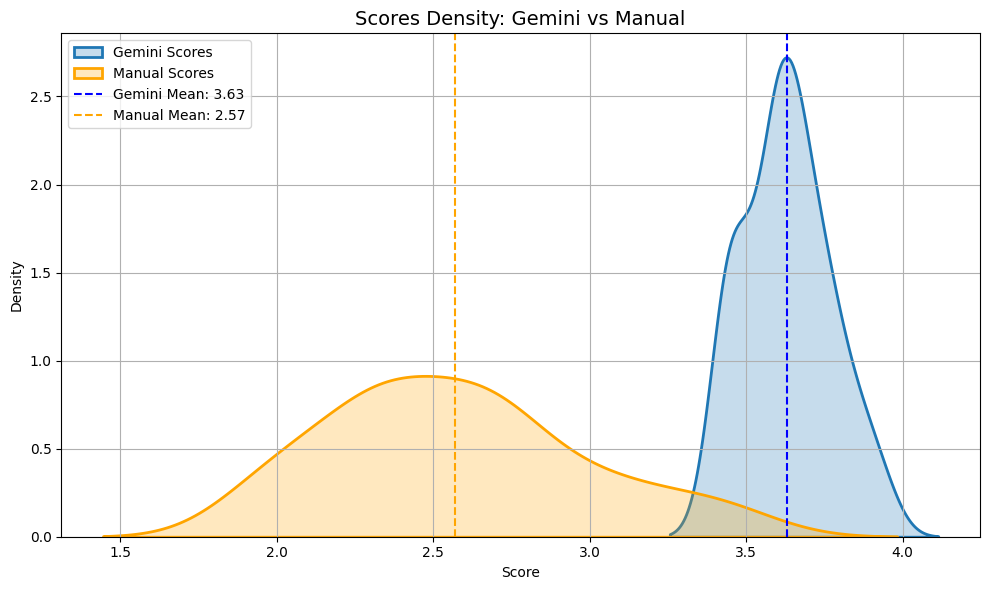

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_ocr.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# T5

In [14]:
scores_t5 = compute_scores(t5_manual, t5_gemini)
scores_t5.head()

,text_index,gemini_score,manual_score
0,0,3.444444,3.000000
1,1,3.222222,2.857143
2,2,3.592593,2.714286
3,3,3.629630,4.000000
4,4,3.481481,4.000000


In [15]:
scores_t5 = compute_scores(t5_manual, t5_gemini)
correlation_t5 = scores_t5['manual_score'].corr(scores_t5['gemini_score'])

print(f"Correlation t5 (Pearson) : {correlation_t5:.3f}")

Correlation t5 (Pearson) : 0.030


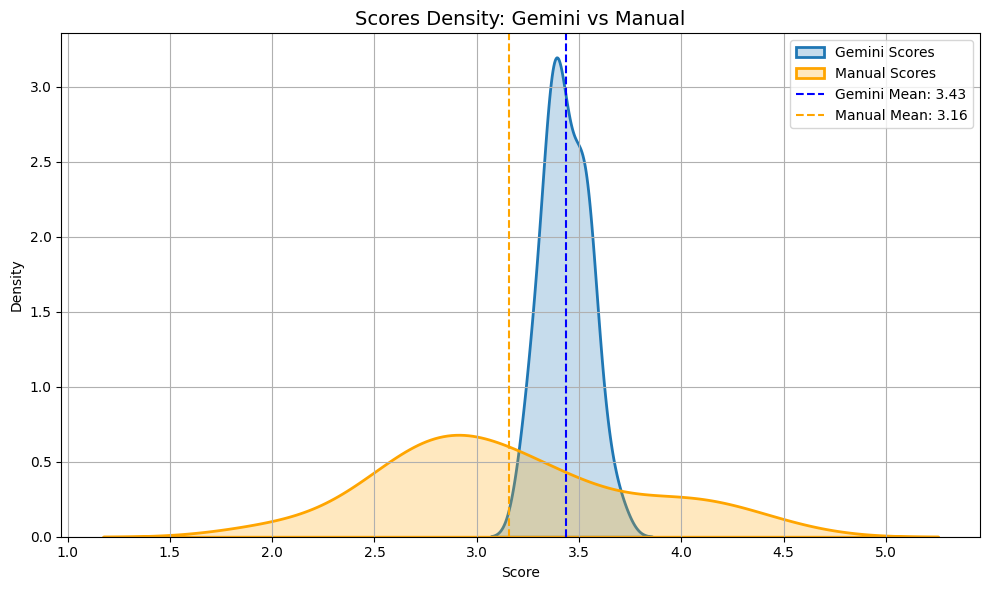

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_t5.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Rouge

# Back translation

In [17]:
scores_bt = compute_scores(bt_manual, bt_gemini)
correlation_bt = scores_bt['manual_score'].corr(scores_bt['gemini_score'])
print(f"Correlation back translation (Pearson) : {correlation_bt:.3f}")

Correlation back translation (Pearson) : 0.059


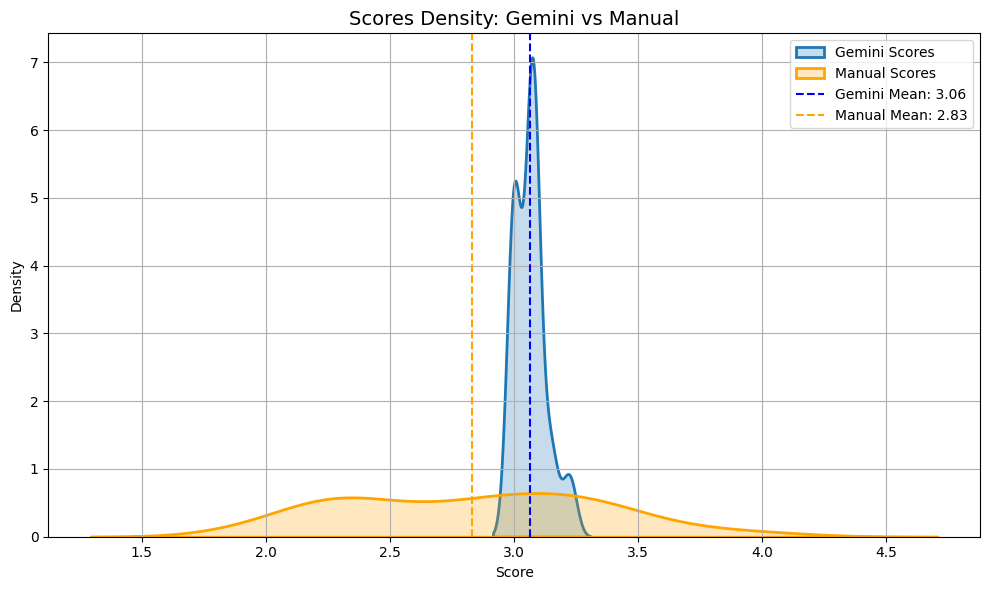

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_bt.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bart

In [19]:
scores_bart = compute_scores(bart_manual, bart_gemini)
correlation_bart = scores_bart['manual_score'].corr(scores_bart['gemini_score'])
print(f"Correlation back translation (Pearson) : {correlation_bart:.3f}")

Correlation back translation (Pearson) : 0.123


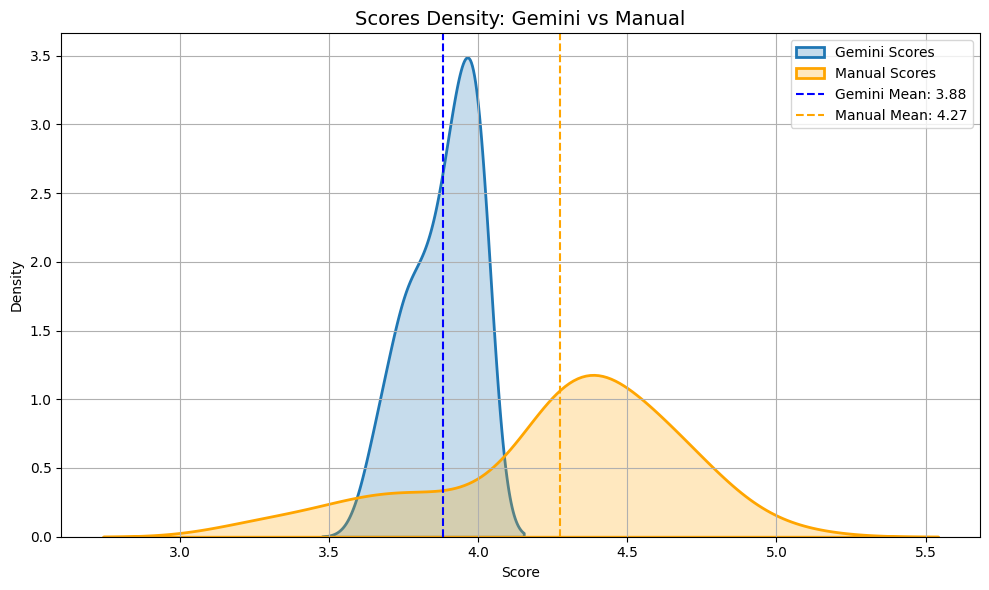

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_bart.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Back translation + T5

In [11]:
scores_bt_t5 = compute_scores(bt_t5_manual, bt_t5_gemini)
scores_bt_t5.head()

,text_index,gemini_score,manual_score
0,0,3.592593,2.714286
1,1,3.925926,2.714286
2,2,3.518519,2.714286
3,3,3.592593,2.714286
4,4,3.703704,3.000000


In [12]:
correlation_bt_t5 = scores_bt_t5['manual_score'].corr(scores_bt_t5['gemini_score'])

print(f"Correlation bt t5 (Pearson) : {correlation_bt_t5:.3f}")

Correlation t5 (Pearson) : -0.008


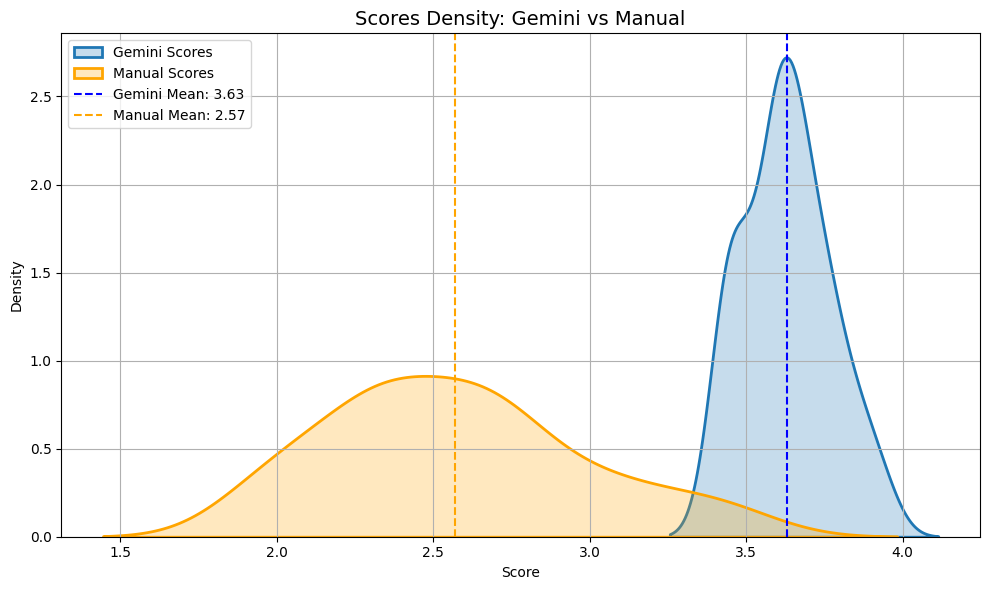

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_bt_t5.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gemini vs Manual

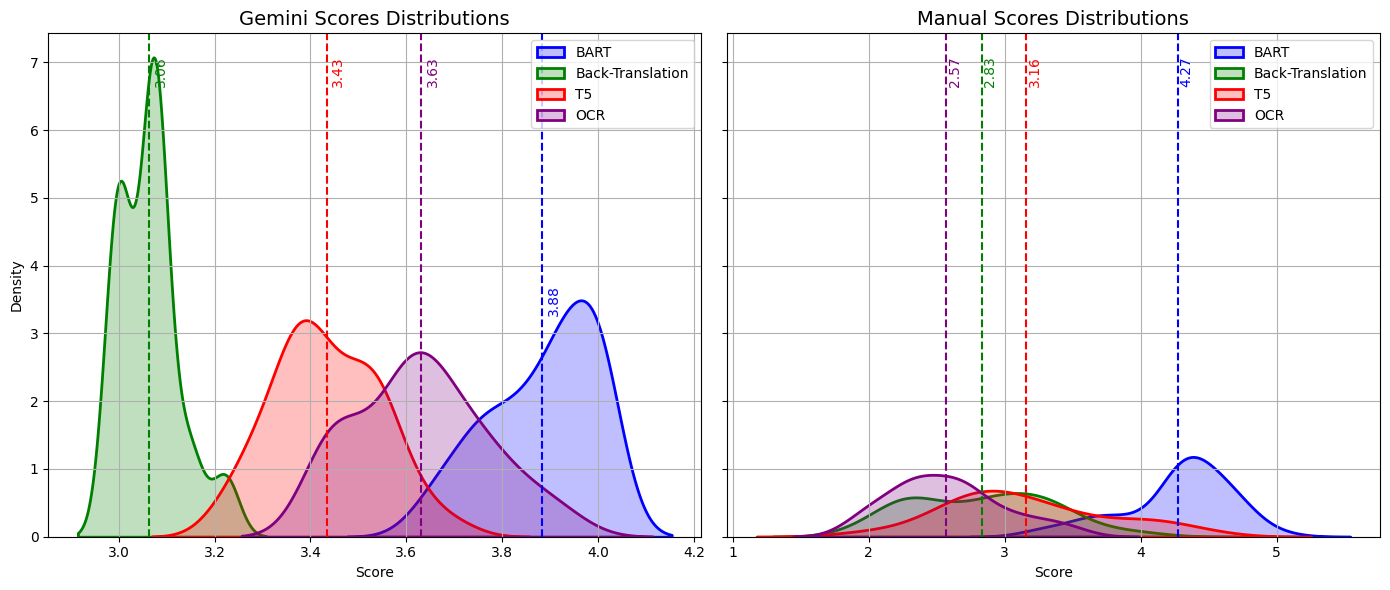

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des DataFrames et des noms
dfs = [scores_bart, scores_bt, scores_t5, scores_ocr, scores_bt_t5]
labels = ['BART', 'Back-Translation', 'T5', 'OCR', 'Back-Translation + T5']
colors = ['blue', 'green', 'red', 'purple', 'yellow']

# Préparer une figure avec 2 sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot des GEMINI scores ---
for df, label, color in zip(dfs, labels, colors):
    sns.kdeplot(df['gemini_score'], ax=axes[0], label=label, fill=True, linewidth=2, color=color)
    mean_val = df['gemini_score'].mean()
    axes[0].axvline(mean_val, color=color, linestyle='--', linewidth=1.5)
    axes[0].text(mean_val + 0.01, axes[0].get_ylim()[1]*0.9, f'{mean_val:.2f}', color=color, rotation=90)

axes[0].set_title("Gemini Scores Distributions", fontsize=14)
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# --- Plot des MANUAL scores ---
for df, label, color in zip(dfs, labels, colors):
    sns.kdeplot(df['manual_score'], ax=axes[1], label=label, fill=True, linewidth=2, color=color)
    mean_val = df['manual_score'].mean()
    axes[1].axvline(mean_val, color=color, linestyle='--', linewidth=1.5)
    axes[1].text(mean_val + 0.01, axes[1].get_ylim()[1]*0.9, f'{mean_val:.2f}', color=color, rotation=90)

axes[1].set_title("Manual Scores Distributions", fontsize=14)
axes[1].set_xlabel("Score")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

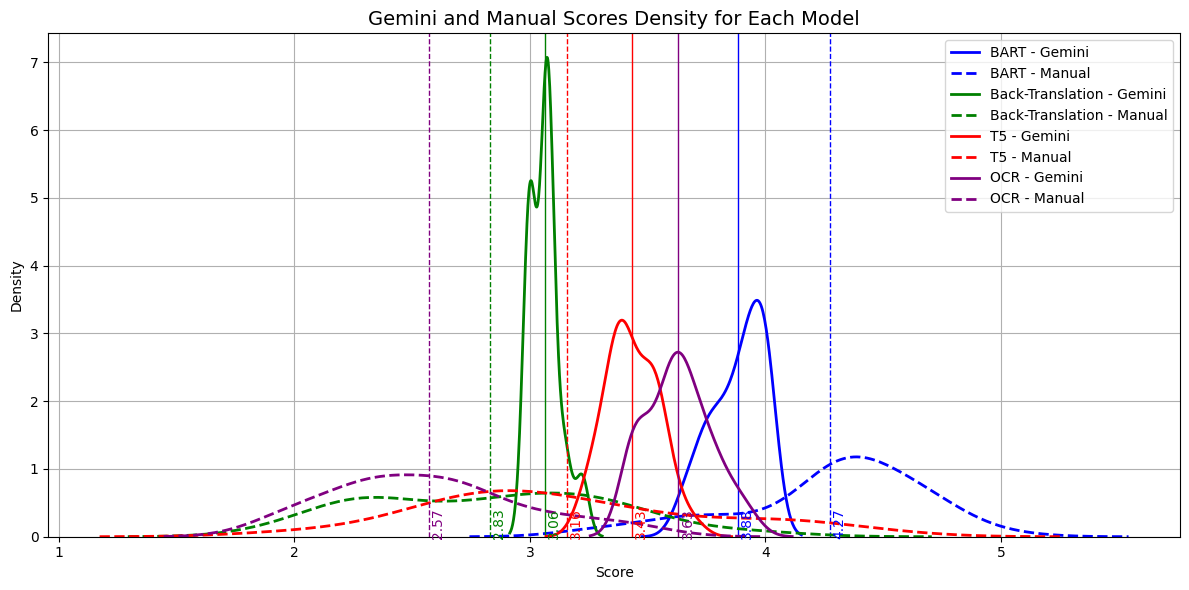

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des DataFrames et des noms
dfs = [scores_bart, scores_bt, scores_t5, scores_ocr, scores_bt_t5]
labels = ['BART', 'Back-Translation', 'T5', 'OCR', 'Back-Translation + T5']
colors = ['blue', 'green', 'red', 'purple', 'yellow']

plt.figure(figsize=(12, 6))

# Tracer les courbes
for df, label, color in zip(dfs, labels, colors):
    # Gemini scores — ligne pleine
    sns.kdeplot(df['gemini_score'], label=f'{label} - Gemini', fill=False,
                linewidth=2, color=color, linestyle='-')
    gemini_mean = df['gemini_score'].mean()
    plt.axvline(gemini_mean, color=color, linestyle='-', linewidth=1)
    plt.text(gemini_mean + 0.01, 0.01, f'{gemini_mean:.2f}', color=color, rotation=90)

    # Manual scores — ligne pointillée
    sns.kdeplot(df['manual_score'], label=f'{label} - Manual', fill=False,
                linewidth=2, color=color, linestyle='--')
    manual_mean = df['manual_score'].mean()
    plt.axvline(manual_mean, color=color, linestyle='--', linewidth=1)
    plt.text(manual_mean + 0.01, 0.01, f'{manual_mean:.2f}', color=color, rotation=90)

plt.title("Gemini and Manual Scores Density for Each Model", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()